In [109]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable

tutorial3に対してデータセットを工夫したやつ

In [110]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import seaborn as sns
import pandas as pd
import sys
import time
import stockpy as st
from datetime import datetime
from tqdm import tqdm

In [111]:
df = yf.download(['AVAV', 'AACI', 'AADI', 'AAL'], period='max')['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [112]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['AVAV'].dropna().values.reshape(-1, 1))


df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)

window_size = 20
n_data = len(df) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i+window_size]

train_labels = train_labels[:, 0]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i+window_size]

train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y

feature_size  = 1
n_hidden  = 64
n_layers  = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MyLSTM(feature_size, n_hidden, n_layers).to(device)

net.load_state_dict(torch.load('./lstm.pth', map_location="cpu"))

func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = []

print(f"run with {device}")
epochs = 10

# net.to(device)

# for i in range(epochs+1):
#     net.train()
#     tmp_loss = 0.0
#     for j, (x, t) in enumerate(train_loader):
#         x = x.to(device)
#         optimizer.zero_grad()
#         y = net(x).to('cpu')
#         loss = func_loss(y, t)
#         loss.backward()
#         optimizer.step() 
#         tmp_loss += loss.item()
#     tmp_loss /= j+1
#     loss_history.append(tmp_loss)
#     print('Epoch:', i, 'Loss_Train:', tmp_loss)

torch.save(net.state_dict(), f'./lstm.pth')

run with cuda


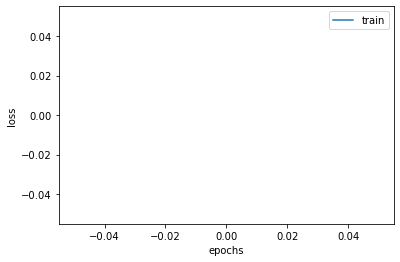

In [113]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [120]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())
    

C:\Users\drryu\AppData\Local\Temp\ipykernel_44660\1814804422.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


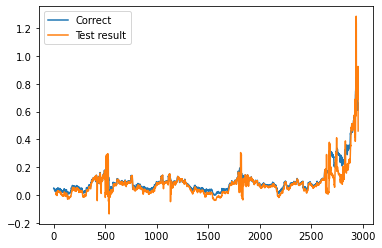

In [121]:

plt.plot(range(len(df_train)), df_train[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Test result')
plt.legend()
plt.show()

In [122]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    predicted_test_plot.append(y[0].item())

In [123]:
# テストデータの最後のデータポイントを取得
last_data_point = torch.tensor(test[-1])
last_data_point = last_data_point.reshape(1, window_size, feature_size)
last_data_point = last_data_point.to(device).float()

n_future=30

for k in range(n_future):
    # LSTMモデルを使用して、未来の値を予測
    y = net(last_data_point)
    predicted_test_plot.append(y[0].item())
    # 予測された値をテストデータに追加
    last_data_point = torch.cat((last_data_point[:, 1:, :], y.reshape(1, 1, 1)), axis=1)
    print(len(last_data_point[0]))
# 予測された値を出力

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [124]:
df_test

array([[0.64629877],
       [0.62779259],
       [0.62404131],
       ...,
       [0.79984994],
       [0.7925975 ],
       [0.8057769 ]])

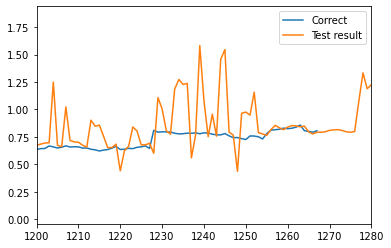

In [128]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.xlim(1200,1280)
plt.legend()
plt.show()

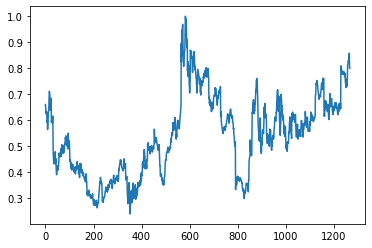

In [157]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')

In [88]:
window_size+len(predicted_test_plot)

76

In [123]:
predicted_test_plot = []
net.eval()

# テストデータの最後のデータポイントを取得
last_data_point = torch.tensor(test[0])
last_data_point = last_data_point.reshape(1, window_size, feature_size)
last_data_point = last_data_point.to(device).float()

n_future=40

for k in range(n_future):
    # LSTMモデルを使用して、未来の値を予測
    y = net(last_data_point)
    predicted_test_plot.append(y[0].item())

    # 予測された値をテストデータに追加
    last_data_point = torch.cat((last_data_point[:, 1:, :], y.reshape(1, 1, 1)), axis=1)
    print(len(last_data_point[0]))
# 予測された値を出力

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


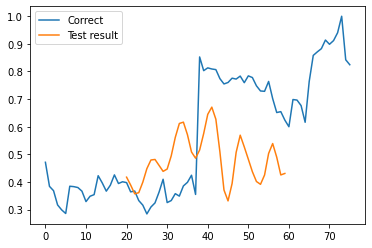

In [125]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()

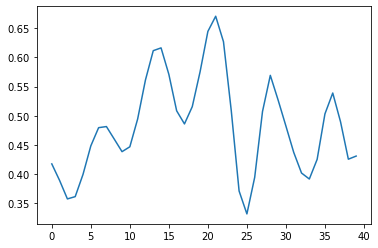

In [124]:
x = range(n_future)
y = predicted_test_plot
plt.plot(x, y, label='Correct')